In [72]:
import pandas as pd
import numpy as np

import sys

sys.path.append("../../../src/evaluation/")

import eval_backend_handler as ebh

df = ebh.get_score_pd()

evaluators = ["joze", "joze2", "ogjoze", "ocenjevalec0",
               "ocenjevalec3", "ocenjevalec5", "ocenjevalec6",
               "ocenjevalec7"]

# keep only valid
df = df[df["scorerId"].isin(evaluators)]
# only eval
df = df[df["textId"].str.startswith("evaluation")]
print(df.head())
# transform textId to number
df["textId"] = df["textId"].apply(lambda x: int(x.split("-")[1]))
df = df.drop_duplicates(subset=["textId", "scorerId"], keep="first")
# everyone should now have 40 scores
print(df["scorerId"].value_counts())


          textId      scorerId  appropriateness  fluency  diversity
78  evaluation-0  ocenjevalec3              1.0      0.0        1.0
79  evaluation-1  ocenjevalec3              4.0      1.0        3.0
80  evaluation-2  ocenjevalec3              2.0      1.0        4.0
81  evaluation-0  ocenjevalec5              3.0      2.0        4.0
82  evaluation-3  ocenjevalec3              4.0      2.0        4.0
scorerId
ocenjevalec3    40
ocenjevalec5    40
ogjoze          40
ocenjevalec6    40
joze            40
ocenjevalec0    40
joze2           40
ocenjevalec7    40
Name: count, dtype: int64


In [67]:
models = ["baseline", "small", "large", "testset"]
    
df["model"] = df["textId"].apply(lambda x: models[x // 10])

In [68]:
per_model_mean = df.groupby("model")[["appropriateness", "fluency", "diversity"]].mean()
per_model_std = df.groupby("model")[["appropriateness", "fluency", "diversity"]].std()

print(f"{'model':10} | {per_model_mean.columns[0]:^19} | {per_model_mean.columns[1]:^19} | {per_model_mean.columns[2]:^19}")
for model in models:
    means = per_model_mean.loc[model].values
    stds = per_model_std.loc[model].values
    print(f"{model:10} | {means[0]:.3f} +- {stds[0]:<10.3f} | {means[1]:.3f} +- {stds[1]:<10.3f} | {means[2]:.3f} +- {stds[2]:<10.3f}")

model      |   appropriateness   |       fluency       |      diversity     
baseline   | 1.875 +- 1.335      | 0.713 +- 0.944      | 3.038 +- 1.163     
small      | 4.375 +- 0.832      | 4.475 +- 0.993      | 1.113 +- 0.914     
large      | 4.350 +- 0.748      | 4.475 +- 0.826      | 1.512 +- 1.031     
testset    | 4.088 +- 1.034      | 4.450 +- 0.825      | 3.112 +- 1.102     


In [69]:
baseline_df = pd.read_csv("../testset/baseline_results.csv", sep="\t")
small_df = pd.read_csv("../testset/T5-small_results.csv", sep="\t")
large_df = pd.read_csv("../testset/T5-large_results.csv", sep="\t")
test_df = pd.read_csv("../testset/testset_results.csv", sep="\t")

eval_set = pd.read_csv("eval.csv", sep="\t")

in_test_idx = eval_set["id"].tolist()[:10]

In [79]:
complete = []
# to keep same order as in eval_set, go over every model
for score_df in [baseline_df, small_df, large_df, test_df]:
    model_scores = []
    # find indexes in same order as in eval_set
    for idx, row in score_df.iterrows():
        if row.iloc[0] in in_test_idx:
            model_scores.append(row.iloc[3:].tolist())
    complete.extend(model_scores)
complete = np.array(complete)

In [111]:
per_text_mean = df.groupby("textId")[["appropriateness", "fluency", "diversity"]].mean()
per_text_mean["overall"] = per_text_mean.mean(axis=1)
print(per_text_mean.head())
human_scores = per_text_mean.values

        appropriateness  fluency  diversity   overall
textId                                               
0                 1.250    0.375      2.750  1.458333
1                 2.125    0.875      3.000  2.000000
2                 1.625    0.375      3.125  1.708333
3                 2.750    1.125      2.375  2.083333
4                 1.375    0.625      2.875  1.625000


In [112]:
print(complete.shape)
print(human_scores.shape)
stacked = np.hstack([complete, human_scores])
print(stacked.shape)

cov = np.corrcoef(stacked.T)

(40, 4)
(40, 4)
(40, 8)


<Axes: >

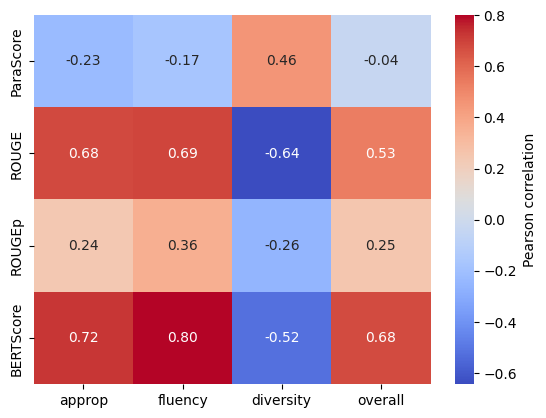

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ["ParaScore",	"ROUGE",	"ROUGEp",	"BERTScore", "approp", "fluency", "diversity", "overall"]

sns.heatmap(cov[:4, 4:], xticklabels=labels[4:], yticklabels=labels[:4], annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Pearson correlation'})
sns.savefig("correlation.pdf")